# Project Overview
I own two microphones, a cheap $3 headset, and a medium quailty podcasting microphone. The difference between the audio recording quality of these two microphones is that the cheap headset does not capture any frequencies over 7000 Hz, leaving the audio "bassy" and dead. This notebook is an attempt to fill in those higher frequencies using deep learning. The basic idea is to take good quality, publicly availible, audio data (LJSpeech Database), create artifical "Cheap Microphone" audio by applying a lowpass filter, and train a Neural Network to repair the audio.

This notebook is a work in progress, **not a final product**. The Procedural version of this notebook is bug free, but the Neural Network needs inproving (see Notes to Self). The OOP version of this notebook is a work in progress. It "works" to train a simple NN, but we can't reproduce the results of the Procedural version until I finish the SplitPipeline and Slicer classes.

- [x] Make it work.
- [ ] Make it right.
- [ ] Make it fast.

### Notes to Self
Reflection on Results
- The non-linear NN is much more complex than the simple linear NN, but Cosine_sym are similar. This suggests to me that there isn't enough information in the fingerprint to make an accurate prediction.
- I'm not entirely surpised by this as the current state-of-the-art is to use convolution NNs. I avoided starting with those due to the additional complexity.
- The current method removes all information about time.
- Before changing to a full on convolution NN, I would like to try adding some recurrent layers (e.g. LSTM) to inject some "time" information into the network.
- Job interview specifies they want at least 5 classes.

ToDo
- Move Fingerprint functions into a fingerprinter class
- Finish SplitPipe and Slicer classes


Deferred
- Set up automatic backups in training
- Add Checks for convergence
  - Since we don't know the right hyperparameters (N-layers,layer type, N-neurons, etc) I should perform a loop over different training parameters and compare the results.
- Implement Bootstraping for uncertainty quantification
- Think about how to merge pipelines (i.e. take individual piplines from multiple datasets and merge them together into 1 pipline).

If issues occur
- Try adding Reccurent layers to restore time information.
- Switch to a Convolution NN
- Normalizing might cause issues... As volume decreases, so does the norm of the FFT. Near zero amplitude, normalizing boosts the signal to meaningless noise. I implemented a threshhold. If max() < thresh, norm = 1 to avoid this.
  - We should try without this to see if it matters.
- Try learning from power spectrum instead.


### Classes
1. Timer
1. Pipelines
  1. SplitPipelines
1. Transformers
  1. FingerprintTransformer
  1. AudioSample
    1. LJSpeechAudioSample
1. Fingerprinter
  1. Fingerprint_1
1. STFT
1. SimpleNN



# Setup

In [1]:
# Initialize modules
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import tensorflow_datasets as tfds # needs pydub

import IPython
import scipy.signal
import inspect

import os
import time
import pickle
import copy
import itertools

# Mount personal google drive to save model
# Mounting your gdrive can be done a couple different ways,
# If you own the file, you only need to do this once.
# Otherwise you need to do it EVERY time.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# load data, there are lots of possible datasets, but ljspeech is one of the smallest relevant ones. Good for a first attempt.
# Est. Load Time: 20 minutes
# https://www.tensorflow.org/datasets/catalog/overview#all_datasets
ds = tfds.load('ljspeech', split='train', shuffle_files=False,) # split='train' uses ALL the data for training, for train test splits see: https://www.tensorflow.org/datasets/splits


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13100 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ljspeech/1.1.0.incompleteZ7M9EY/ljspeech-train.tfrecord*...:   0%|          | …

Dataset ljspeech downloaded and prepared to ~/tensorflow_datasets/ljspeech/1.1.0. Subsequent calls will reuse this data.


# Define Ancillary Functions for Fingerprinting
- Depreciation Warning!
- I am in the process of moving these functions to the Fingerprinter inner class of AudioSample


In [4]:
#ToDo, move these to AudioSample.Fingerprinter
#ToDo, Write spectra_to_fingerprint function

def ComplexToDual(ComplexSpectra):
  """Takes a complex STFT and seperates the real and imaginary parts.
  
  Parameters:
    ComplexSpectra: A NxM array of complex numbers.

  Returns:
    Dual (np.array): A 2NxM array where rows 0 to N-1 are
      the real portion of the complex numbers and N to 2N-1 are the complex part.
  """
  REAL = np.real(ComplexSpectra)
  I = np.imag(ComplexSpectra)
  Dual = tf.concat([REAL, I], 0) # slap imaginary part on bottom
  #Dual = [Real,I] # Store real / img parts in a list
  #print(REAL==I) # debug
  return Dual


# takes flattened stft and converts it back to a complex stft
def DualToComplex(fingerprint):
  """Inverse function of ComplexToDual."""
  # Designed for 1D arrays!
  if len(fingerprint)%2 == 0: # if not divisible by two something is wrong...
    nfreq = len(fingerprint)//2
    REAL = fingerprint[:nfreq]
    I = fingerprint[nfreq:]
    COMPLEX = [ complex(r,i) for (r,i) in zip(REAL,I)]
    COMPLEX = np.array(COMPLEX, dtype=np.complex128)
    return COMPLEX
  else:
    print("Issue in DualToComplex, length of fingerprint not divisible by two. Missing Real/Imaginary info.")
    raise


# Functionalizing just in case I want to change this
def NormalizeFP(sxx, thresh=1):
  """Scales a Dual spectra so the max value is 1."""
  norms=np.apply_along_axis(lambda c: max(c) if max(c) > thresh else 1, axis=0, arr=sxx) # pull out max value of each column, if max is near 0, norm is 1 to avoid issues
  fingerprints = np.apply_along_axis(lambda c: c/norms, axis=1, arr=sxx) # divide each row by it's realated column max

  return (fingerprints, norms)


def DenormalizeFP(normedfps, norms):
  """Inverse of NormalizeFP."""
  fingerprints = np.apply_along_axis(lambda c: c*norms, axis=1, arr=normedfps) # multiply each row by it's related column max
  return fingerprints


# ToDo redo to take an auido sample object
def FingerprintToWave(fps, norms, istft):
  sxx = DenormalizeFP(fps, norms)
  #print(sxx.shape)
  sxx = [ DualToComplex(s) for s in sxx.T ] # deflatten stft, need to optimize
  sxx = np.array(sxx).T # Cols are FFTs
  #print(sxx.shape)
  waveform = istft(sxx)
  return waveform


def FPtoSpectra(fps, norms):
  sxx = DenormalizeFP(fps, norms)
  #print(sxx.shape)
  sxx = [ DualToComplex(s) for s in sxx.T ] # deflatten stft, need to optimize
  sxx = np.array(sxx).T # Cols are FFTs

  return sxx


# Define and Test Classes

In [5]:
# A performance timer
class Timer:

  #all_timers = []

  def __init__(self, prec=2):
    """Create a performance timer."""
    self._t0=0
    self._t1=0 # see tictoc
    self.prec=prec
    self.times= []
    #self.all_timers.append(self) # hmm... I'm not sure how I feel about this yet

  def tic(self):
    """Set timer start Time."""
    self._t0 = time.perf_counter()
    self._t1 = time.perf_counter()

  def toc(self):
    """Print and store elapsed time."""
    t1 = time.perf_counter()
    dt = t1-self._t0
    self.times.append(dt)

    self._t1 = t1 # see tictoc
    
    # Determine if we should report time in hours, minutes, or seconds,
    if dt >= 3600*2: # *2 bc I would rather 90 mins over 1.5 hours
      unit='hours'
      factor=3600
    elif dt >= 60*2: # *2 bc I would rather 75 secs over 1.25 min
      unit='minutes'
      factor=60
    else:
      unit='seconds'
      factor=1

    # Report Runtime
    print(f'Elapsed Time: {round(dt/factor, self.prec)} {unit}')


  def tictoc(self):
    """Print and store elapsed time from previous toc or tictoc command."""
    self._t0 = self._t1
    self.toc()


  def describe(self):
    """Use PandasDataFrame.describe method to describe saved times."""
    if len(self.times) > 0:
      print(pd.DataFrame(T.times).describe())
    else:
      print(r'No times recorded')

  def reset(self):
    """Delete saved times."""
    self.times = []
    self._t0 = 0
    self._t1 = 0

In [6]:
# Test Timer
print(1)
T = Timer(prec=5)
T.describe()
print()

print(2)
T.tic()
time.sleep(0.123456789)
T.toc()
print()

print(3)
T = Timer()
T.tic()
time.sleep(0.123456789)
T.toc()
print()

print(4)
T.tic()
T._t0-=120
T.toc()
print()

print(5)
T.tic()
T._t0-=3600*2
T.toc()
print()

print(6)
T.reset()
T.describe()
print()

print(7)
T.tic
for i in range(5):
  time.sleep(0.5)
  T.tictoc()
T.describe()


1
No times recorded

2
Elapsed Time: 0.12401 seconds

3
Elapsed Time: 0.12 seconds

4
Elapsed Time: 2.0 minutes

5
Elapsed Time: 2.0 hours

6
No times recorded

7
Elapsed Time: 25.07 minutes
Elapsed Time: 0.5 seconds
Elapsed Time: 0.5 seconds
Elapsed Time: 0.5 seconds
Elapsed Time: 0.5 seconds
                 0
count     5.000000
mean    301.181746
std     672.343017
min       0.500778
25%       0.500785
50%       0.500804
75%       0.500866
max    1503.905499


In [7]:
class Transformers:
  """Take in an object, perform operations, add fingerprinting related methods"""
  def __init__(self) -> None:
    pass # default, return an object with just fingerprinting methods
  
  # Methods all transformers should have
  def fingerprint(self):
    #debug
    if self._fingerprinter.check_required_props(self): # returns True as expected
      self._fingerprinter.fingerprint(self)

    '''debug
    if self._fingerprinter.check_required_props(self):
      self._fingerprinter.fingerprint(self)
    else:
      print('Missing required properties to use that fingerprint style!')
      print('No fingerprints calculated.')
    '''

  def check_required_props(self, element):
    return True

  def attach_fingerprinter(self, fingerprinter):
    self._fingerprinter = fingerprinter

    if fingerprinter.check_required_props(self):
      self.fingerprint()
    else:
      # ToDo: Update with more info
      print('Missing required properties to use that fingerprint style!')
      print('Fingerprinter attached, but no fingerprints calculated.')
    
  def copy(self):
    #return copy.deepcopy(self)
    return copy.copy(self)



class FingerprintTransformer(Transformers):
  """Outputs an object with a '.fingerprints' attribute equal to the input.
  
  The Pipeline objects will be expecting an input object with a '.fingerprints'
  attribute. When debuging / prototyping function this allows you to
    directly pass a pre-formated figureprint using a dummy container object.
  """
  def __init__(self, element):
    # Create a new object, with attribute fingerprints equal to input
    self.fingerprints = element


  def check_required_props(element):
    # FingerprintTransformers aren't fingerprinters
    return False

In [8]:
class Pipeline:
  """The Pipeline class transforms an input dataset and returns generator.
  
  The class is useful for abstration of the ML training process and combining 
  different dataset sources. 
  Takes in an iterable dataset and a transformer class.
  Iteration over the '.samples' attribute returns transformed elements of the dataset.
  """
  def __init__(self, transformer=None, dataset=None, gen_dataset=None, tf_output_types=None):  
    self.dataset = dataset # iterable, priority over gen_dataset
    self.gen_dataset = gen_dataset # method that returns a iterable generator
    self.tf_output_types = tf_output_types # must be iterable of tf types
                                           # or as_tf_ds will throw an error
    
    if transformer is None:
      self.transformer = FingerprintTransformer
    else:
      self.transformer = transformer


  #\@property # This messes things up when you try to chain pipes together
  def samples(self):
    """Returns a generator containing formated elements of the input dataset."""
    if self.dataset is not None:
      return (self.transformer(e) for e in self.dataset)
    else:
      return (self.transformer(e) for e in self.gen_dataset() )

    
  # generator for tf.data.Dataset.from_generator
  def generate_fp_target_pairs(self):
    for s in self.samples():
      yield (s.fingerprints, s.targets)


  def as_tf_ds(self):
    DS = tf.data.Dataset.from_generator(self.generate_fp_target_pairs, output_types=self.tf_output_types)
    return DS


class SplitPipeline(Pipeline):
  """A Pipeline designed to yield multiple output samples per input sample."""
  
  def samples(self):
    """Returns a generator containing formated elements of the input dataset."""
    if self.dataset is not None:
      wholes = (self.transformer(e) for e in self.dataset)
    else:
      wholes = (self.transformer(e) for e in self.gen_dataset())
    
    parts = (whole.parts for whole in wholes )

    return ( p for p in itertools.chain(*parts) )


In [9]:
# Test Pipeline
fakedata = [ i for i in range(6) ]
pipe = Pipeline(dataset=fakedata)

# Test 1 - Reusable generators
temp = pipe.dataset
print(np.array(temp==pipe.dataset).all())
print()

L = []
for i in pipe.samples():
  L.append(i.fingerprints)

M=[]
for i in pipe.samples():
  M.append(i.fingerprints)

print(np.array(L==M).all())
#print(type(pipe.samples)) # debug

True

True


In [10]:
# Test 2 - Custom Transformer
class transformed(Transformers):
  def __init__(self, obj):
    self.fingerprints = obj.fingerprints
    self.targets = self.fingerprints*2
    self.fp_output_type = tf.int32
    self.target_output_type = tf.int32

pipe2 = Pipeline(transformer=transformed, gen_dataset=pipe.samples)

# debug
#print(type(pipe2.samples)) 
#print(type(pipe2.dataset))

# Manual creation of fp, target pairs
L=[]
for s in pipe2.samples():
  t = (s.fingerprints, s.targets)
  L.append(t)
  print(t)

print()
# Test Reusability
M=[]
for s in pipe2.samples():
  t = (s.fingerprints, s.targets)
  M.append(t)
#print(np.array(M==L).all())
print(M==L)

(0, 0)
(1, 2)
(2, 4)
(3, 6)
(4, 8)
(5, 10)

True


In [11]:
# Test out tf Dataset generation
DS = tf.data.Dataset.from_generator(pipe2.generate_fp_target_pairs, output_types=(tf.int32, tf.int32))

M=[]
for d in DS:
  M.append(d)
print(M==L)

True


In [12]:
class AudioSample(Transformers):
  """Holds the properties of an audio file.

  The AudioSample class exists to accumulate information about
  a specific audio sample and allow for easy investigation.
  It can hold information important to machine learning,
  but any heavy lifting should be handled by something else, like an inner class.

  See the inner class Fingerprinter for fingerprinting.
  """

  def __init__(self, waveform, sample_rate, fingerprinter=None, stft_obj=None):
    # self.fingerprints # holds actual fingerprint of audio
    # ? Change .fingerprints to .fp?

    # update stuff
    self.waveform = waveform
    self.sample_rate = sample_rate
    self.f, self.t, self.zxx = 3*[None]
    self.attach_stft_obj(stft_obj)

    # Do this last, as attach_fingerprint checks for compatibility
    if fingerprinter is not None:
      self.attach_fingerprinter(fingerprinter)
    else:
      # If none given, attach a fingerprinter of type 1
      pass
      #self.attach_fingerprinter(self.Fingerprint_1() )
      
    # Manually update self.targets or automate in fingerprinter.fingerprint()
      

  ### Methods

  ## AudioSample specific methods
  def attach_stft_obj(self, stft_obj):
      self._stft_obj = stft_obj

  def play_audio(self, normalize=True):
    audio = IPython.display.Audio(self.waveform, rate=self.sample_rate, normalize=normalize)
    IPython.display.display(audio)

  def show_spectra(self, yscale='linear', refresh=False):

    def test():
      # If we don't have time, frequency, or complex spectra, we need to calculate them
      for item in [self.t, self.f, self.zxx]:
        if item is None:
          return True
      return False

    if refresh or test(): # If data is missing or forced recalc
      if self._stft_obj is None: # check for STFT obj
        print('You need to attach a STFT object to plot the STFT!')
        return

      # Calculate new stft
      self.f, self.t, self.zxx = self._stft_obj.stft(self.waveform, self.sample_rate)

    self._stft_obj.plot_spectra(self.t, self.f, self.zxx, yscale=yscale)
    # Edit to return plot ax?


  ''' ToDo
  def play_fp(self, normalize=True):
    #wave = # convert fingerprint back to waveform  
    # play wave
    pass # debug
  '''

  ### inner classes
  class Fingerprinter:
    def __init__(self) -> None:
      pass # will update once we have more than 1 fingerprint style

    def check_required_props(self, obj):
      # ToDo, update this
      return True

    # Identity Fingerprint
    def fingerprint(self, obj):
      return obj



  class Fingerprint_1(Fingerprinter):
    def __init__(self) -> None:
      super().__init__()
      pass #debug


    def check_required_props(self, audio_sample):
      """Checks to see if an object to be fingerprinted has all the required properties.

      returns True if object is compatible with this fingerprint style and has
      all the nessesary attributes.

      returns False if object is not compatible.
      """
      try:
        for attr in [audio_sample.waveform,
                    audio_sample.sample_rate,
                    audio_sample._stft_obj,
                    ]:
          if attr is  None:
            return False
        return True
      except Exception as e:
        # if an attribute is missing we will throw an error
        print(f'Exception thrown:{e}')
        return False


    def fingerprint(self, audio_sample):
      """Encode a single waveform with a short-time-fourier-transform."""
      
      f, t, zxx = audio_sample._stft_obj.stft(audio_sample.waveform, audio_sample.sample_rate)

      # Split Complex numbers into real an imaginary parts
      sxx = ComplexToDual(zxx) # self

      # I'd rather augment data than normalize, but training is currently too slow
      fingerprints, norms = NormalizeFP(sxx) # Normalizing might cause issues with small signals

      # attach properties to audio_sample
      for i,j in zip(['f','t','zxx','fingerprints','norms'],[f,t,zxx,fingerprints,norms]):
        setattr(audio_sample, i, j)

      return
      #return f, t, zxx, fingerprints, norms


### AudioSample Subclasses
class LJSpeechAudioSample(AudioSample):
  """A subclass of AudioSample optimized for the LJSpeech database.

  Every database is structured slightly differently.
  Subclasses are one way we can massage different datasets into the same form.
  A "from_ljspeech()" method to AudioSample is another way.
  """
  # Special class to make audio sample from the ljaudio database
  def __init__(self, element, **kwargs):
    # Sample Rate from: https://keithito.com/LJ-Speech-Dataset/
    super().__init__(element['speech'], sample_rate=22050, **kwargs)

In [13]:
class STFT:
  """Creates a Short-Time-Fourier-Transformer."""
  # Should I put sample rate into stft_settings?
  # I intentionally removed it, but I'm re-thinking that...
  def __init__(self, **stft_settings):
    self.stft_settings = stft_settings

  def stft(self, waveform, sample_rate):
    # filter out unnecessary stft_settings
    sig = inspect.signature(scipy.signal.stft)
    allowed_keys = [ key for key in sig.parameters if key not in ['x', 'fs'] ]
    filtered_settings = { k:self.stft_settings[k] for k in self.stft_settings if k in allowed_keys}
    
    return scipy.signal.stft(waveform, fs=sample_rate, **filtered_settings)

  def istft(self, sxx, sample_rate):
    # filter out unnecessary stft_settings
    sig = inspect.signature(scipy.signal.istft)
    allowed_keys = [ key for key in sig.parameters if key not in ['Zxx', 'fs'] ]
    filtered_settings = { k:self.stft_settings[k] for k in self.stft_settings if k in allowed_keys}
    
    return scipy.signal.istft(sxx, fs=sample_rate, **filtered_settings)


  @staticmethod
  def plot_spectra(t, f, sxx, yscale='linear'):
    # Works for both spectragrams (sxx) and fingerprints (dual form of spectragrams)

    # For complex form
    try:
      y = f
      plt.pcolormesh(t, f, abs(sxx),
                    shading='gouraud', cmap='inferno',
                    norm=colors.LogNorm() # Log COLOR scale
                    )
    # For Dual form
    except TypeError:
      y = np.concatenate([f,-1*f])
      plt.pcolormesh(t, y, abs(sxx),
                    shading='gouraud', cmap='inferno',
                    norm=colors.LogNorm() # Log COLOR scale
                    )
    
    plt.title('Short-Time-Fourier-Transform')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.yscale(yscale)
    plt.ylim(min(y),max(y))
    plt.show()


  # Depreciated
  @staticmethod
  def low_pass_filter_old1(freqs, sxx, f1, f2):
    # takes in a list of real frequencies and a 2D spectragram (rows = freq, cols = time)
    # reduces / sets the freqs over the cutoff to zero
    # should work on 1D or 2D spectras
    # For Dual spectras call low_pass_filter(freqs.append(freqs), sxx, f1, f2)
    # So freq info exists for imaginary part

    # create mask
    if f1 == f2:
      mask = [ 1 if f < f1  else 0 for f in freqs ] # single row filter
    else:
      mask = [ 1 if f < f1  else 0 if (f > f2)  else (f2-f)/(f2-f1)  for f in freqs ] # single row filter
    
    try:
      mask = [ mask for i in range(sxx.shape[1]) ] # each row is a filter
    except IndexError: # 1D arrays throw an IndexError
      pass

    mask = np.array(mask).T # transpose so each col is a filter

    sxx = mask*sxx # EagerTensor has no copy
    return sxx 



In [14]:
# Test out AudioSample class
# Test 1 - confirm AudioSample stores waveform
for e in ds:
  s = AudioSample(e['speech'], sample_rate=22050)
  break
print(np.array(e['speech']==s.waveform).all())

# Test 2 - confirm LJSpeech subclass works
s = LJSpeechAudioSample(e)
print(np.array(e['speech']==s.waveform).all())

# Test 3 - Confirm check_required_props works
# Test 3a
s = LJSpeechAudioSample(e)
fptr = AudioSample.Fingerprint_1()
print( not fptr.check_required_props(s) ) # we haven't attached a STFT yet

# Test 3b
stft_obj = STFT()
s.attach_stft_obj(stft_obj)
print(fptr.check_required_props(s) ) # we have attached a STFT yet

True
True
True
True


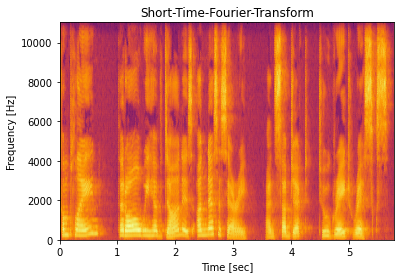

In [15]:
# AudioSample and STFT Test Cont.
s.show_spectra()
s.play_audio()

# Test Pipeline and More Classes

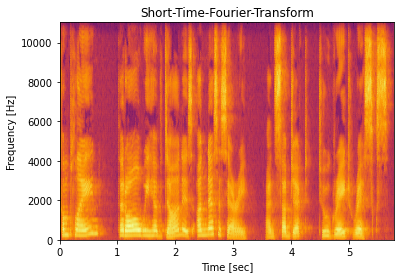

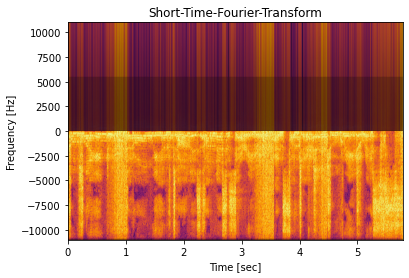

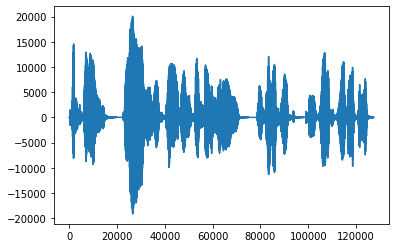

In [22]:
# Create Pipeline from LJSpeech Data
stft_obj = STFT()
fptr = AudioSample.Fingerprint_1()

LJpipe = Pipeline(transformer=lambda e:
                    LJSpeechAudioSample(e, fingerprinter=fptr, stft_obj=stft_obj),
                  dataset=ds,
                  #tf_output_types= (tf.float64, tf.float64) # debug
                  )

# Test Full Pipeline
for s in LJpipe.samples():
  s.show_spectra()
  #ToDo add show fingerprint method
  # ToDo Check this, I don't remeber coding negative freqs
  STFT.plot_spectra(s.t, s.f, s.fingerprints)
  plt.plot(s.waveform)
  plt.show()
  s.play_audio()
  break


In [17]:
# Create Function to augment data
def CheapMicro(audio_sample):
  # Makes a copy
  Q = audio_sample.copy()
  
  # move full fingerprint(dualstft) to targets
  Q.targets = Q.fingerprints
  
  # create filtered signal
  sos = scipy.signal.butter(10, 6000, 'lp', fs=Q.sample_rate, output='sos') # low pass filter
  filtered_wave = scipy.signal.sosfilt(sos, Q.waveform)
  Q.waveform = filtered_wave # update waveform
  Q.fingerprint() # update fingerprints, also refreshes spectral info

  return Q

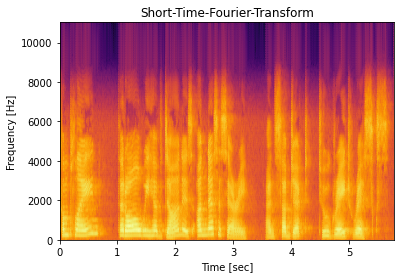

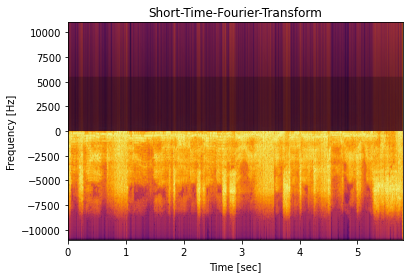

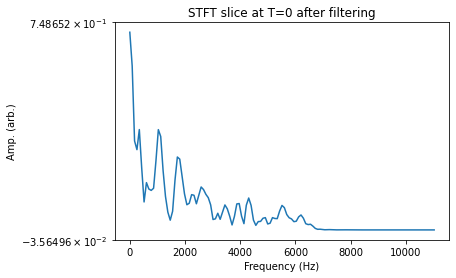

In [18]:
# Test it out
Q = CheapMicro(s)
Q.show_spectra(refresh=True) # New Spectra!
STFT.plot_spectra(Q.t, Q.f, Q.fingerprints) # new fingerprints
Q.play_audio() # degraded audio

# Look at a cross section of stft
plt.plot(Q.f, abs(Q.zxx[:,0]))
plt.yscale('symlog')
plt.title('STFT slice at T=0 after filtering')
plt.ylabel('Amp. (arb.)')
plt.xlabel('Frequency (Hz)')
plt.show()

In [19]:
# ToDo, work in progress
class Slicer(Transformers):
  """A class to split 2D stft into 1D stft."""
  
  def builder(self, audio_sample):
    whole = audio_sample.copy()
    whole.parts = ( part for part in self.splitter(audio_sample) )

    return whole


  def splitter(self, audio_sample):
    ffts = (S for S in audio_sample.fingerprints.T)
    targets = (t for t in audio_sample.targets.T)
    for f,t in zip(ffts,targets):
      part = audio_sample.copy()
      part.fingerprints = f
      part.targets = t
      
      yield part


In [20]:
class FixedWidth(AudioSample): # Todo, move to AudioSamples
  """A class to chop down long signals or pad short ones.

  Neural Networks require fingerprints of known length.
  """
  def __init__(self, audio_sample, width):
    super().__init__(audio_sample.waveform, audio_sample.sample_rate)
    self.width = width
    #self.waveform = audio_sample.waveform
    #self.sample_rate = audio_sample.sample_rate
    
    self.crop()
    self.pad()

    self.attach_stft_obj(audio_sample._stft_obj)
    self.attach_fingerprinter(audio_sample._fingerprinter)


  def crop(self):
    """Crops long waveforms down to self.width."""
    if len(self.waveform) > self.width:
      self.waveform = self.waveform[0:self.width]

  def pad(self):
    """Pad waveform to be a minimum length."""
    L = len(self.waveform)
    if L < self.width:
      dW = int(L-self.width)
      self.waveform = np.concatenate([ self.waveform, dW*[0] ]) # pad end with zeros


class TheChopper(AudioSample):
  def __init__(self, audio_sample, width=1):
    super().__init__(audio_sample.waveform, audio_sample.sample_rate,
                             stft_obj=audio_sample._stft_obj,
                             fingerprinter=audio_sample._fingerprinter,
                             )
    self.width = width
    self.waveform = self.crop(self.waveform)
    self.waveform = self.pad(self.waveform)

    self.t =self.pad(self.crop(self.t))

    self.fingerprints = self.crop(self.pad(self.fingerprints))

    try:
      self.targets = self.crop(audio_sample.targets)
    except AttributeError:
      pass # might not have a target yet

  def crop(self, fps):
    """ Designed to chop down fingerprints."""
    fps = fps.T # chop in time
    if len(fps) > self.width:
      fps = np.array(fps[0:self.width])
    
    fps = fps.T
    return fps

  def pad(self,fps):
    """Pad waveform to be a minimum length."""
    fps = np.array(fps).T # chop in time
    L = len(fps)
    if L < self.width:
      W = self.width-L
      fps = np.concatenate( (fps, W*[0]) ) # pad end with zeros
    
    return fps.T
  

    

# Create and Test Full Pipeline!

LJpipe
(258, 997)


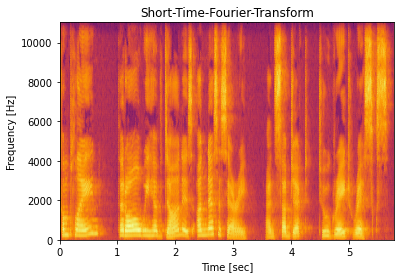

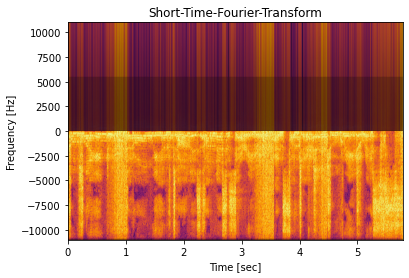

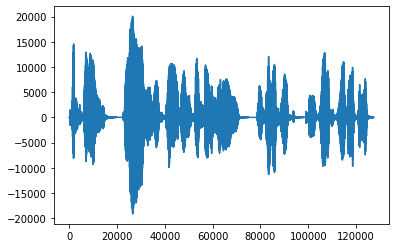

In [23]:
# Create Pipeline from LJSpeech Data to CheapMicro to TheChopper to NN
LJpipe = Pipeline(transformer=lambda e:
                    LJSpeechAudioSample(e, 
                                        fingerprinter=AudioSample.Fingerprint_1(),
                                        stft_obj=STFT(),
                                        ),
                  dataset=ds,
                  #tf_output_types= (tf.float64, tf.float64),
                  )

for s in LJpipe.samples():
  print('LJpipe')
  print(s.fingerprints.shape) # depends on STFT settings
  s.show_spectra()
  #ToDo add show fingerprint method
  # ToDo Check this, I don't remeber coding negative freqs
  STFT.plot_spectra(s.t, s.f, s.fingerprints) # show fingerprint
  plt.plot(s.waveform)
  s.play_audio()
  break

cheap
(258, 997)


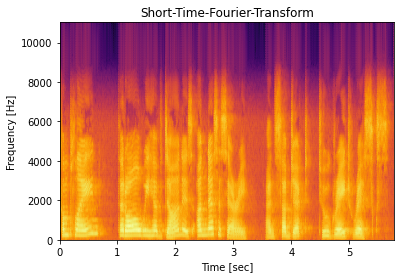

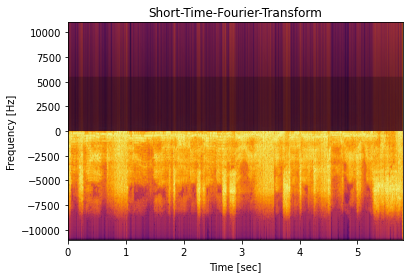

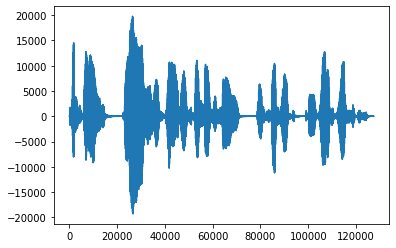

In [24]:
cheap_pipe = Pipeline(transformer=CheapMicro,
                      gen_dataset=LJpipe.samples,
                      tf_output_types= (tf.float64, tf.float64)
                      )

for s in cheap_pipe.samples():
  print('cheap')
  print(s.fingerprints.shape) # depends on STFT settings
  s.show_spectra()
  #ToDo add show fingerprint method
  # ToDo Check this, I don't remeber coding negative freqs
  STFT.plot_spectra(s.t, s.f, s.fingerprints) # show fingerprint
  plt.plot(s.waveform)
  s.play_audio()
  break


The plan is to split the audio sample into individual FFTs slices using SplitPipeline.
However, SplitPipeline is still in development.
To get things working for now we will
simply take the first slice of the stft to train the model.
The results won't be great, but it will show that the simpleNN works.

fixed_pipe
(258, 1)


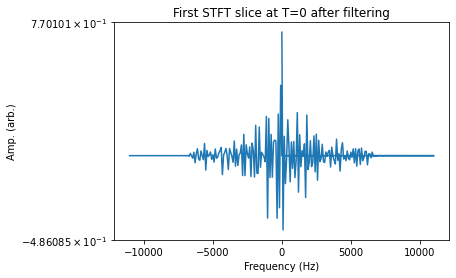

In [25]:
fixed_pipe = Pipeline(transformer=lambda e: TheChopper(e, 1),
                      gen_dataset=cheap_pipe.samples,
                      tf_output_types= (tf.float64, tf.float64)
                      )

for s in fixed_pipe.samples():
  print('fixed_pipe')
  print(s.fingerprints.shape)
  #STFT.plot_spectra(s.t, s.f, s.fingerprints)
  plt.plot(np.concatenate([s.f,-1*s.f]), s.fingerprints)
  plt.yscale('symlog')
  plt.title('First STFT slice at T=0 after filtering')
  plt.ylabel('Amp. (arb.)')
  plt.xlabel('Frequency (Hz)')
  plt.show()
  break


# Define a Simple Dense Neural Network

In [26]:
class SimpleNN:
  def __init__(self, N, M, input_shape=(258,1), activation=None, savefile=None, savedir=r'.'):
    # Set up Dense NN
    model = keras.Sequential([
      keras.layers.Flatten(input_shape=input_shape), # I give cols, but tf wants rows
      ])
    
    for i in range(N):
      model.add(keras.layers.Dense(M, activation=activation))
    # Last layer is output layer, fidelity must match number of frequncy bins
    model.add(keras.layers.Dense(1026, activation=activation)) # debug

    model.compile(
      optimizer='adam',                   # try adam, adadelta, and ftrl
      loss="mean_squared_error",          # Try MSE and cosine_similarity
      metrics=["mean_squared_error", 'cosine_similarity'] 
      )

    self.model = model
    # Set up autosaving / pickling
    self.savedir=savedir # '/content/drive/MyDrive/Colab Notebooks'
    self.savefile=savefile
    if savefile is None:
      print(r'WARNING! No filename set for saving model. Pickling Impossible!')


  # save model to pickle file
  def pickle(self):
    if self.savefile is None:
      print(r'Set self.savefile="filename.pickle" to enable pickling')
      return
    
    CWD = os.getcwd() # Current working directory
    os.chdir(self.savedir)
    with open(self.savefile, 'wb') as f:
        pickle.dump(self, f)
    os.chdir(CWD)

  # Load model from pickle file
  @staticmethod
  def unpickle(savefile, savedir=r'.'):
    CWD = os.getcwd() # Current working directory
    os.chdir(savedir)
    with open(savefile, 'rb') as f:
        simpleNN = pickle.load(f)
    os.chdir(CWD)

    return simpleNN


# Train our NN! Attempt 1
- Version 1 training ran about 275ms per slice, or 6 seconds per 32 slice batch on CPUs, previous data exploration training ran about 4ms per slice on GPUs.
- After optimizing functions this ran at 8ms per slice on CPUs! No batching/prefetch
- For a simple NN with only Input and Output layers with 1026 neurons and linear activation, MSE converges with less than 300,000 slices.
  - There are 2,491,672 slices in the lj dataset.
  - MSE = 0.0055, Cosine_sym= 0.858
- Once training is done we should cluster the dataset based on the MSE.
- Increasing the Batch size seems to have done a great deal to improve the final accuracy (Cosine_sym ~0.95), but additional epochs haven't helped.

In [27]:
# Keep graph clean
from keras import backend as K
K.clear_session()

T = Timer() # Create Performance Timers

# instantiate Simple Neural Network
simpleNN = SimpleNN(0,258, input_shape=(258,1),
                    savefile=r'simpleNN_hidden0_epoch1.pickle',
                    savedir=r'/content/drive/MyDrive/Colab Notebooks/FrequencyFiller',
                    )

# Turn Pipelines into a TensorFlowDataset
DS = fixed_pipe.as_tf_ds()

# fit NN
T.tic()
simpleNN.model.fit(DS.prefetch(tf.data.AUTOTUNE), epochs=1, steps_per_epoch=10)#000) # use steps_per_epoch to limit run time by limiting number of samples
T.toc()

simpleNN.pickle()

10/10 [==============================] - 6s 328ms/step - loss: 0.0326 - mean_squared_error: 0.0326 - cosine_similarity: 0.0211
Elapsed Time: 7.51 seconds


In [ ]:
# Batching is broken for some reason...
# Batch Training
simpleNN = SimpleNN.unpickle(savefile=r'simpleNN_hidden0_epoch1.pickle', savedir=r'/content/drive/MyDrive/Colab Notebooks/FrequencyFiller')

simpleNN.model.fit(DS.batch(100).prefetch(tf.data.AUTOTUNE), epochs=1, batch_size=100, steps_per_epoch=1)
#simpleNN.model.fit(DS.batch(5000).prefetch(tf.data.AUTOTUNE), epochs=4, batch_size=5000, steps_per_epoch=20) # This usually runs faster, but limiting to get an example
simpleNN.savefile = r'simpleNN_hidden0_batch5000_epoch4.pickle'
#simpleNN.pickle()

# Deep Learning Network

In [ ]:
# Keep graph clean
from tensorflow.keras import backend as K
K.clear_session()

# Create Training Dataset
pipe = CustomPipelines.pipeline_1(ds)
DS = pipe.get_training_dataset()
T = Timer() # Create Performance Timers

# instantiate Simple Neural Network
deepNN = SimpleNN(4,1026, savefile=r'deepNN_hidden0_epoch1.pickle', savedir=r'/content/drive/MyDrive/Colab Notebooks/FrequencyFiller')

# fit NN
T.tic()
deepNN.model.fit(DS.prefetch(tf.data.AUTOTUNE), epochs=1, steps_per_epoch=300000) # use steps_per_epoch to limit number of sample / run time
T.toc()

deepNN.pickle()

300000/300000 [==============================] - 1484s 5ms/step - loss: 24489.2969 - mean_squared_error: 24446.6973 - cosine_similarity: 0.0174
Elapsed Time: 25.38 minutes


In [ ]:
# Batch Training
#deepNN = SimpleNN.unpickle(savefile=r'deepNN_hidden0_epoch1.pickle', savedir=r'/content/drive/MyDrive/Colab Notebooks/FrequencyFiller')

deepNN.model.fit(DS.batch(5000).prefetch(tf.data.AUTOTUNE), epochs=4, batch_size=5000)#, steps_per_epoch=60)
deepNN.savefile = r'deepNN_hidden0_batch5000_epoch4.pickle'
deepNN.pickle()

Epoch 1/4
746/746 [==============================] - 1500s 2s/step - loss: 11.4584 - mean_squared_error: 11.4584 - cosine_similarity: 0.0195
Epoch 2/4
227/746 [========>.....................] - ETA: 17:17 - loss: 7.5223 - mean_squared_error: 7.5223 - cosine_similarity: 0.0232

# Test it out!

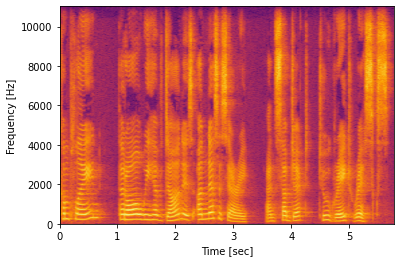

In [ ]:
pipe = CustomPipelines.pipeline_1(ds) #debug

# Pull 1 audio sample from dataset
sample_n=0 # sample number you want to examine

n=0
for audio_sample in pipe.audio_samples:
  sample = audio_sample
  #f, t, sample.fingerprints, sample.norms = pipe.get_fingerprint(sample.waveform, sample.sample_rate, sample.stft_obj.stft)
  #sample.f_fps = STFT.low_pass_filter(np.concatenate([f,f]), sample.fingerprints, **LPF_settings)
  n+=1
  if n > sample_n:
    break


sample.show_spectra()
sample.play_audio()

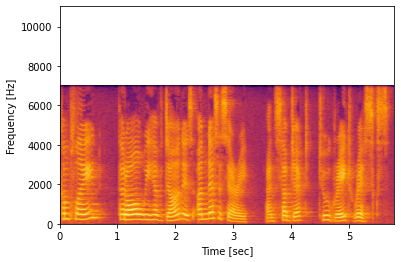

In [ ]:
#STFT.plot_spectra(sample.t, sample.f, sample.f_zxx)
synth_audio = AudioSample(FingerprintToWave(sample.f_fps, sample.f_norms,
                                            lambda zxx: sample.stft_obj.istft(zxx, sample.sample_rate) ),
                          sample.sample_rate, stft_obj=sample.stft_obj)
synth_audio.t = sample.t
synth_audio.f = sample.f
synth_audio.zxx = sample.f_zxx

synth_audio.show_spectra()
synth_audio.play_audio()

# The rest of the notebook is broken
When I changed from functional programming to OOP I deleted functions to increase readability. Unfortunately, I haven't had the time to create new classes for non-linear Neural Networks yet so the rest of this notebook doesn't work. There are still some pretty pictures though.

If you want to check out a functioning non-linear NN, checkout the functional-filler branch on GitHub: https://github.com/enykwest/FrequencyFiller/blob/functional-filler/FrequencyFiller_TrainAndTest.ipynb

# Train NN, attempt 2
Attempt 1 used a simple 1 layer NN with linear or Relu activation. Linear activation gave a nice, full, spectragram, but lacked some of the fine details. The Relu method was SPARSE, and possibly needed more 1-sample training epochs. Neither method sounded great, but they did seem slightly better.

This section of the notebok is deticated to building more complicated networks by following: https://keras.io/guides/training_with_built_in_methods/

In [ ]:
# Set up saving
#from google.colab import drive
#drive.mount('/content/drive')
import os
CWD = os.getcwd()
print(CWD)

from tensorflow.keras import backend as K
from tensorflow.keras import layers
K.clear_session()

inputs = keras.Input(shape=(1026,), name="inputs") # feed in full STFT slice, 0-11,000ish Hz
categories = layers.Dense(26, activation="softmax", name="categorize")(inputs) # try and categorize slice

upper_fill = layers.Dense(470, activation="tanh", name="upper_fill_OnOff")(categories) # based on category, turn on, or off, different freqs (limited to missing freqs for now)
#upper_fill = layers.Dense(470, activation=None, name="upper_fill")(upper_fill) # fill in upper freqs with linear relationship, can be considered as a non-negative amplitude
upper_fill = layers.Dense(470, activation="relu", name="upper_fill")(upper_fill) # fill in upper freqs with linear relationship, can be considered as a non-negative amplitude

concat = layers.Concatenate(axis=1)([inputs, upper_fill]) # add guess info to OG signal (i.e. increase length of fingerprint)
outputs = layers.Dense(1026, activation=None, name="predictions")(concat) # Must allow for negative values seen in fingerprint
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', # try adam, adadelta, and ftrl
              loss="mean_squared_error",
              metrics=["mean_squared_error", 'cosine_similarity'] # Accuracy is only for classifiers. Try MSE and cosine_similarity
              )


#DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(pseudods), output_types=(tf.float64, tf.float64) )
DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(ds), output_types=(tf.float64, tf.float64) )

t1=tic()
#model.fit(DS.batch(200).prefetch(tf.data.AUTOTUNE), epochs=1)
model.fit(DS.batch(1).prefetch(tf.data.AUTOTUNE), batch_size=1, epochs=1,)# steps_per_epoch=1000) # debug
t2=tic()
print("Training: {} hours".format((t2-t1)/(60*60)))

# save model
savefile = r'deep1_epoch1.pickle'
MLD = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(MLD)
import pickle
with open(savefile, 'wb') as f:
    pickle.dump(model, f)
os.chdir(CWD)

/content
2491672/2491672 [==============================] - 11151s 4ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.8636
Training: 3.106505738496111 hours


# Restart from Pickle


In [ ]:
savefile = r'deep1_epoch1.pickle'
import os
CWD = os.getcwd()
print(CWD)
MLD = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(MLD)
import pickle
t1=tic()
with open(savefile, 'rb') as f:
  model = pickle.load(f)
t2=tic()
os.chdir(CWD)
print("Load: {} seconds".format(t2-t1))


/content
Load: 2.7538030379998872 seconds


In [ ]:
DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(ds), output_types=(tf.float64, tf.float64) )

t1=tic()
model.fit(DS.batch(1).prefetch(tf.data.AUTOTUNE), epochs=4, batch_size=1,)# steps_per_epoch=1000)
t2=tic()
print("Training: {} hours".format((t2-t1)/(60*60)))

# save model
os.chdir(MLD)
with open(r'deep1_epoch5.pickle', 'wb') as f:
    pickle.dump(model, f)
os.chdir(CWD)

In [ ]:
DS = tf.data.Dataset.from_generator(lambda: GenerateTrainingData(ds), output_types=(tf.float64, tf.float64) )

t1=tic()
model.fit(DS.batch(5000).prefetch(tf.data.AUTOTUNE), epochs=4, batch_size=5000,)# steps_per_epoch=1)
t2=tic()
print("Training: {} hours".format((t2-t1)/(60*60)))

# save model
os.chdir(MLD)
with open(r'deep1_batch5000_epoch4.pickle', 'wb') as f:
    pickle.dump(model, f)
os.chdir(CWD)

Epoch 1/4
499/499 [==============================] - 1040s 2s/step - loss: 0.0023 - mean_squared_error: 0.0023 - cosine_similarity: 0.9452
Epoch 2/4
499/499 [==============================] - 1042s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - cosine_similarity: 0.9513
Epoch 3/4
499/499 [==============================] - 1018s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - cosine_similarity: 0.9514
Epoch 4/4
499/499 [==============================] - 1042s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - cosine_similarity: 0.9514
Training: 1.1506965575074999 hours


# Test it out!

In [ ]:
# Pick an audio file
nmax=1
n=0
for e in ds:
  waveform = e['speech']
  n+=1
  if n >= nmax:
    break

# Fingerprint and predict
f, t, fingerprints, norms = Fingerprint(waveform)

# Simulate Loss in quality
f_fps = LowPassFilter(np.concatenate([f,f]), fingerprints, **LPF_settings)
guess = model.predict(f_fps.T) # "Repair" audio with NN
print(guess.T.shape) 

6/6 [==============================] - 1s 17ms/step
(1026, 167)


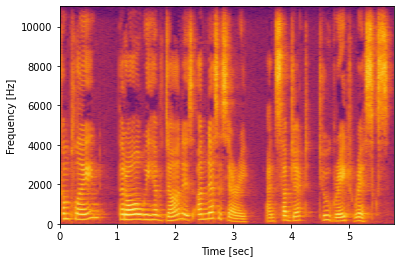

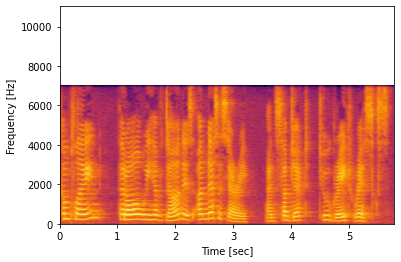

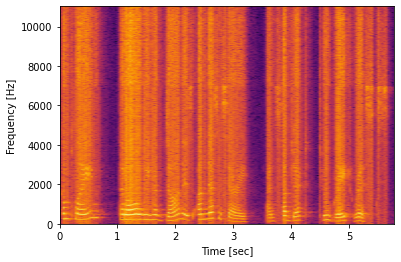

In [ ]:
ShowSpectra(t, f, FPtoSpectra(fingerprints, norms))
ShowSpectra(t, f, FPtoSpectra(f_fps, norms))
ShowSpectra(t, f, FPtoSpectra(guess.T, norms))

In [ ]:
import pandas as pd
look = pd.DataFrame(fingerprints)
look.describe().round(2)

0        1        2        3        4        5        6        7    \
count  1026.00  1026.00  1026.00  1026.00  1026.00  1026.00  1026.00  1026.00   
mean     -0.00     0.00    -0.00    -0.00     0.00    -0.00    -0.00     0.00   
std       0.12     0.12     0.09     0.05     0.04     0.10     0.13     0.15   
min      -0.82    -0.97    -1.64    -0.73    -0.57    -2.12    -1.55    -0.68   
25%      -0.03    -0.04    -0.00    -0.00    -0.00    -0.00    -0.03    -0.06   
50%      -0.00     0.00     0.00     0.00     0.00     0.00    -0.00     0.00   
75%       0.03     0.04     0.00     0.00     0.00     0.00     0.03     0.06   
max       1.00     1.00     1.00     1.00     1.00     1.00     1.00     1.00   

           8        9    ...      157      158      159      160      161  \
count  1026.00  1026.00  ...  1026.00  1026.00  1026.00  1026.00  1026.00   
mean      0.00    -0.00  ...     0.00     0.00    -0.00     0.00     0.00   
std       0.08     0.09  ...     0.18     0.21     0.15     0.16     0.14   
min      -0.76    -1.54  ...    -1.07    -1.17    -1.04    -1.18    -1.16   
25%      -0.00    -0.00  ...    -0.05    -0.03    -0.02    -0.01    -0.01   
50%      -0.00    -0.00  ...    -0.00    -0.00    -0.00     0.00    -0.00   
75%       0.00     0.00  ...     0.05     0.04     0.01     0.01     0.01   
max       1.00     1.00  ...     1.00     1.00     1.00     1.00     1.00   

           162      163      164      165      166  
count  1026.00  1026.00  1026.00  1026.00  1026.00  
mean     -0.00    -0.00    -0.00    -0.00     0.00  
std       0.14     0.17     0.19     0.14     0.12  
min      -0.80    -1.09    -1.61    -1.12    -0.69  
25%      -0.01    -0.04    -0.03    -0.03    -0.05  
50%       0.00    -0.00    -0.00     0.00     0.00  
75%       0.01     0.04     0.03     0.03     0.05  
max       1.00     1.00     1.00     1.00     0.73  

[8 rows x 167 columns]

In [ ]:
# Listen to "fingerprinted" audio (quality might differ from OG)
filtered_audio = FingerprintToWave(fingerprints,norms)

IPython.display.Audio(filtered_audio, rate=sample_rate, normalize=True)

In [ ]:
# Listen to filtered audio
filtered_audio = FingerprintToWave(f_fps,norms)

IPython.display.Audio(filtered_audio, rate=sample_rate, normalize=True)

In [ ]:
# Listen to "Repaired" Audio
guessed_audio = FingerprintToWave(guess.T,norms)

IPython.display.Audio(filtered_audio, rate=sample_rate, normalize=True)